In [1]:
# Imports
import numpy as np
import os
import matplotlib.image as mpimg
import torch
from torch.distributions import Normal
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image
import torchvision.datasets as datasets
from keras.datasets import mnist
from torch.utils.data import Dataset
import torch




In [15]:
def loadTissueData(path_to_file):
    '''
    Read image intensity, multiclass-segmentations, and PD, T1, T2 (tissue properties)
    for multi-slice SAX images of the ACDC dataset
    dimensions are : [1,N_slices,Nx,Ny]

    all cases are have been previously resampled to 1x1 mm in-plane resolution and 10 mm slice thickness
    '''

    data = np.load(path_to_file)
    image = data['image']
    multiClass = data['multiClassMasks']
    PD = data['PD']
    T1 = data['T1']
    T2 = data['T2']

    return image,multiClass,PD,T1,T2

def loadLVOnly(path_to_file):
    '''
    Read only LV segmentation masks
    '''

    multiClass = np.load(path_to_file)['multiClassMasks']
    LV_mask = 1*(multiClass == 3)
    return LV_mask

def load_mask(path_to_file, i):
    '''
    Read out channel i only from the data
    '''

    multiClass = np.load(path_to_file)['multiClassMasks']
    mask = 1*(multiClass == i)
    return mask

slices_images,multiClass, PD, T1, T2 = loadTissueData("../npzdata/patient090.npz")

LV_mask = loadLVOnly("../npzdata/patient090.npz")




In [16]:
multiClass.shape

(12, 7, 256, 256)

In [17]:
def get_multichannel_data():
    """ Retrieves the data for the multi-channel background data

    nr_images = depending on the amount of data selected with the training_start and training_end variables in the meta_data.py file
    channels = 11 , only background the backgrounds, specifically excludes the LV mask
    image_height = 256
    image_width = 256
    
    Returns: The connected data for the multi-channel model in the shape of [nr_images, channels, image_height, image_width]
    

    """


    for i in range (99,100):

        #missing patient 84 and 88
        if(i==84 or i == 88):
            continue
        path = f'../npzdata/patient0{i}.npz'


        #take in first data
        multi_channel = load_mask(path,0)

        #reshape the slices and time to single images  ( ASK AGAIN!)
        nr_of_images = multi_channel.shape[0] * multi_channel.shape[1]

        #resahpe to prepare for concatenation
        multi_channel = multi_channel.reshape(nr_of_images,1, 256, 256)


        for j in range(1,12):

            # exclude the LV to only get background!
            if(j==3):
                continue
            channel = load_mask(path, j)

            channel = channel.reshape(nr_of_images,1, 256, 256)

            #concatenate along channels
            multi_channel = np.concatenate((multi_channel, channel), axis=1)

        if(i==99):
            all_multi_channel = multi_channel
        else:
            #concatenate along the images of the patients
            all_multi_channel= np.concatenate((all_multi_channel, multi_channel), axis=0)
            
            

    #shuffle data to exclude the time dependence of the generated images that persits in the data
    #if the images are just concatenated (in the original form they come as slices | time , and we just flatten them)
    np.random.shuffle(all_multi_channel)

    # turn numpy into torch tensor
    all_multi_channel = torch.from_numpy(all_multi_channel)
    all_multi_channel = all_multi_channel.type(torch.float32)
    

    print(f'All multi channel shape: {all_multi_channel.shape}')

    return all_multi_channel

In [18]:
multichannel_data = get_multichannel_data()



All multi channel shape: torch.Size([304, 11, 256, 256])


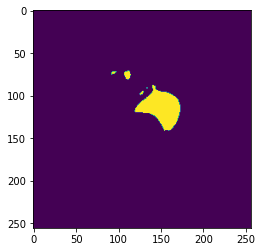

In [6]:

### 0RV Bloodpool  1LV blood pool and 2 RV, 3 is LV (removed here in background) wall are the backgrounds interested 

plt.imshow(multichannel_data[204,0,:,:])

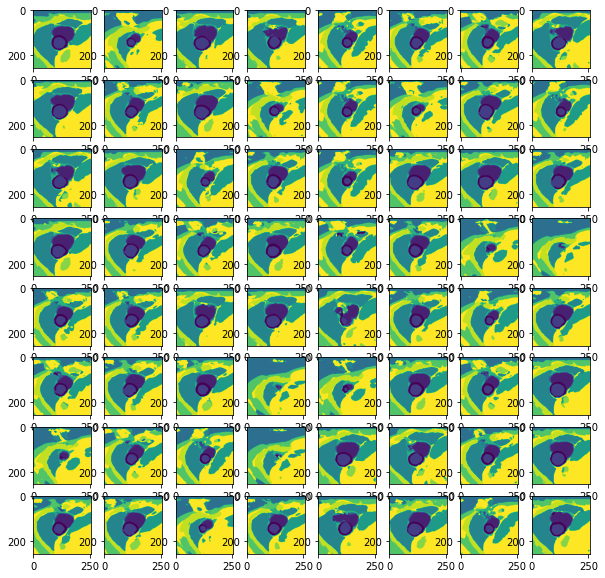

In [23]:
### checking if image reconstruction works 


multichannel_data.shape
final_image = np.zeros((64,256,256))
fig = plt.figure(figsize=(10, 10))
for j in range (64):

    for i in range(multichannel_data.shape[1]):
        final_image[j,:,:]= (multichannel_data[j,i,:,:].numpy() * (i+1) + final_image[j,:,:])
        

for j in range (64):        
    plt.subplot(8, 8, j+1)
    plt.imshow(final_image[j])
plt.savefig(f'../outputs/reconstructionstest.jpg')

In [48]:
final_image.shape

(256, 256)

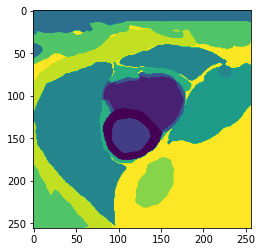

In [60]:
final_image_no_lv = np.zeros((256,256))
for i in range(multichannel_data.shape[1]):
    final_image_no_lv += (multichannel_data[1,i,:,:].numpy() * (i+1))
        
plt.imshow(final_image_no_lv)

In [ ]:
##checking and comparing if the image shuffle works properly along all channels!

In [ ]:
plt.imshow(multichannel_data[1,10,:,:])

In [ ]:
multi_channel_shuffled = get_multichannel_data()

np.random.shuffle(multi_channel_shuffled)


In [ ]:
plt.imshow(multi_channel_shuffled[23,4,:,:])

In [ ]:
final_image_no_lv_shuffled = np.zeros((256,256))
for i in range(multi_channel_shuffled.shape[1]):
    final_image_no_lv_shuffled+= (multi_channel_shuffled[100,i,:,:].numpy() * (i+1))
plt.imshow(final_image_no_lv_shuffled)

In [ ]:
## Pertubation:

nr_of_images = multichannel_data.shape[0]
multichannel_data = multichannel_data.detach().numpy()

#id_sampled = np.random_choiche(np.arange(),n_samples)

In [ ]:
## from stefano: use for permuation of multichannel data ! ranodm choice does not guarantte all images are chosen when pemruated!!! not unqie !! from the sampling!

#id_sampled = np.random_choiche(np.arange(N_images),n_samples)
#Images[id_sampled,…]
#training_set = Images[id_sampled,…]


In [ ]:
id_sampled = np.random.choice(100,100)
print(id_sampled)

m = np.zeros_like(id_sampled, dtype=bool)

m[np.unique(id_sampled, return_index=True)[1]] = True

print(m)



In [ ]:
#Impage testing
from torchvision.utils import save_image


In [13]:
recon_images= multi_channel_shuffled[0:64,:,:]
final_image = torch.zeros((64,256,256))
print(recon_images.shape)
for k in range(64):
    for i in range(11):
        final_image[k,:,:] +=(recon_images[k,i,:,:].cpu().detach().numpy() * (i+1))
        print(f'recon_images shape unsqueezed: {recon_images.cpu().shape}')
        print(f'final_image shape: {final_image.shape}')
        recon_images_unsqueezed = torch.unsqueeze(recon_images[:,i,:,:].cpu(),1)
        #save_image(recon_images_unsqueezed, f'./test_reconimage{i}.jpg')
final_image_unsqueezed = torch.unsqueeze(final_image,1)


plt.imshow(final_image_unsqueezed)
#save_image(final_image_unsqueezed, './testfinalimage.jpg')

NameError: name 'multi_channel_shuffled' is not defined

In [2]:
pip install cairo

ERROR: Could not find a version that satisfies the requirement cairo (from versions: none)
ERROR: No matching distribution found for cairo
Note: you may need to restart the kernel to use updated packages.


In [11]:
## Flooring for dice
x = np.random.rand(256,256)

In [12]:
rounded = np.rint(x)

In [13]:
rounded

array([[0., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.]])

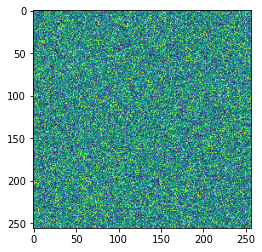

In [23]:
plt.imshow(x)

sample = multichannel_data[0:64,:,:] * x + x

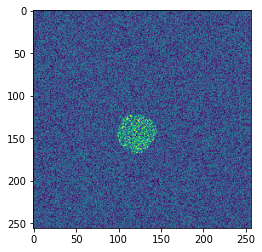

In [24]:
plt.imshow(sample[1,1,:,:])

In [25]:
sample_rounded = np.rint(sample)

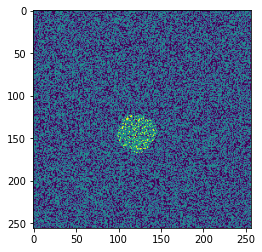

In [26]:
plt.imshow(sample_rounded[1,1,:,:])

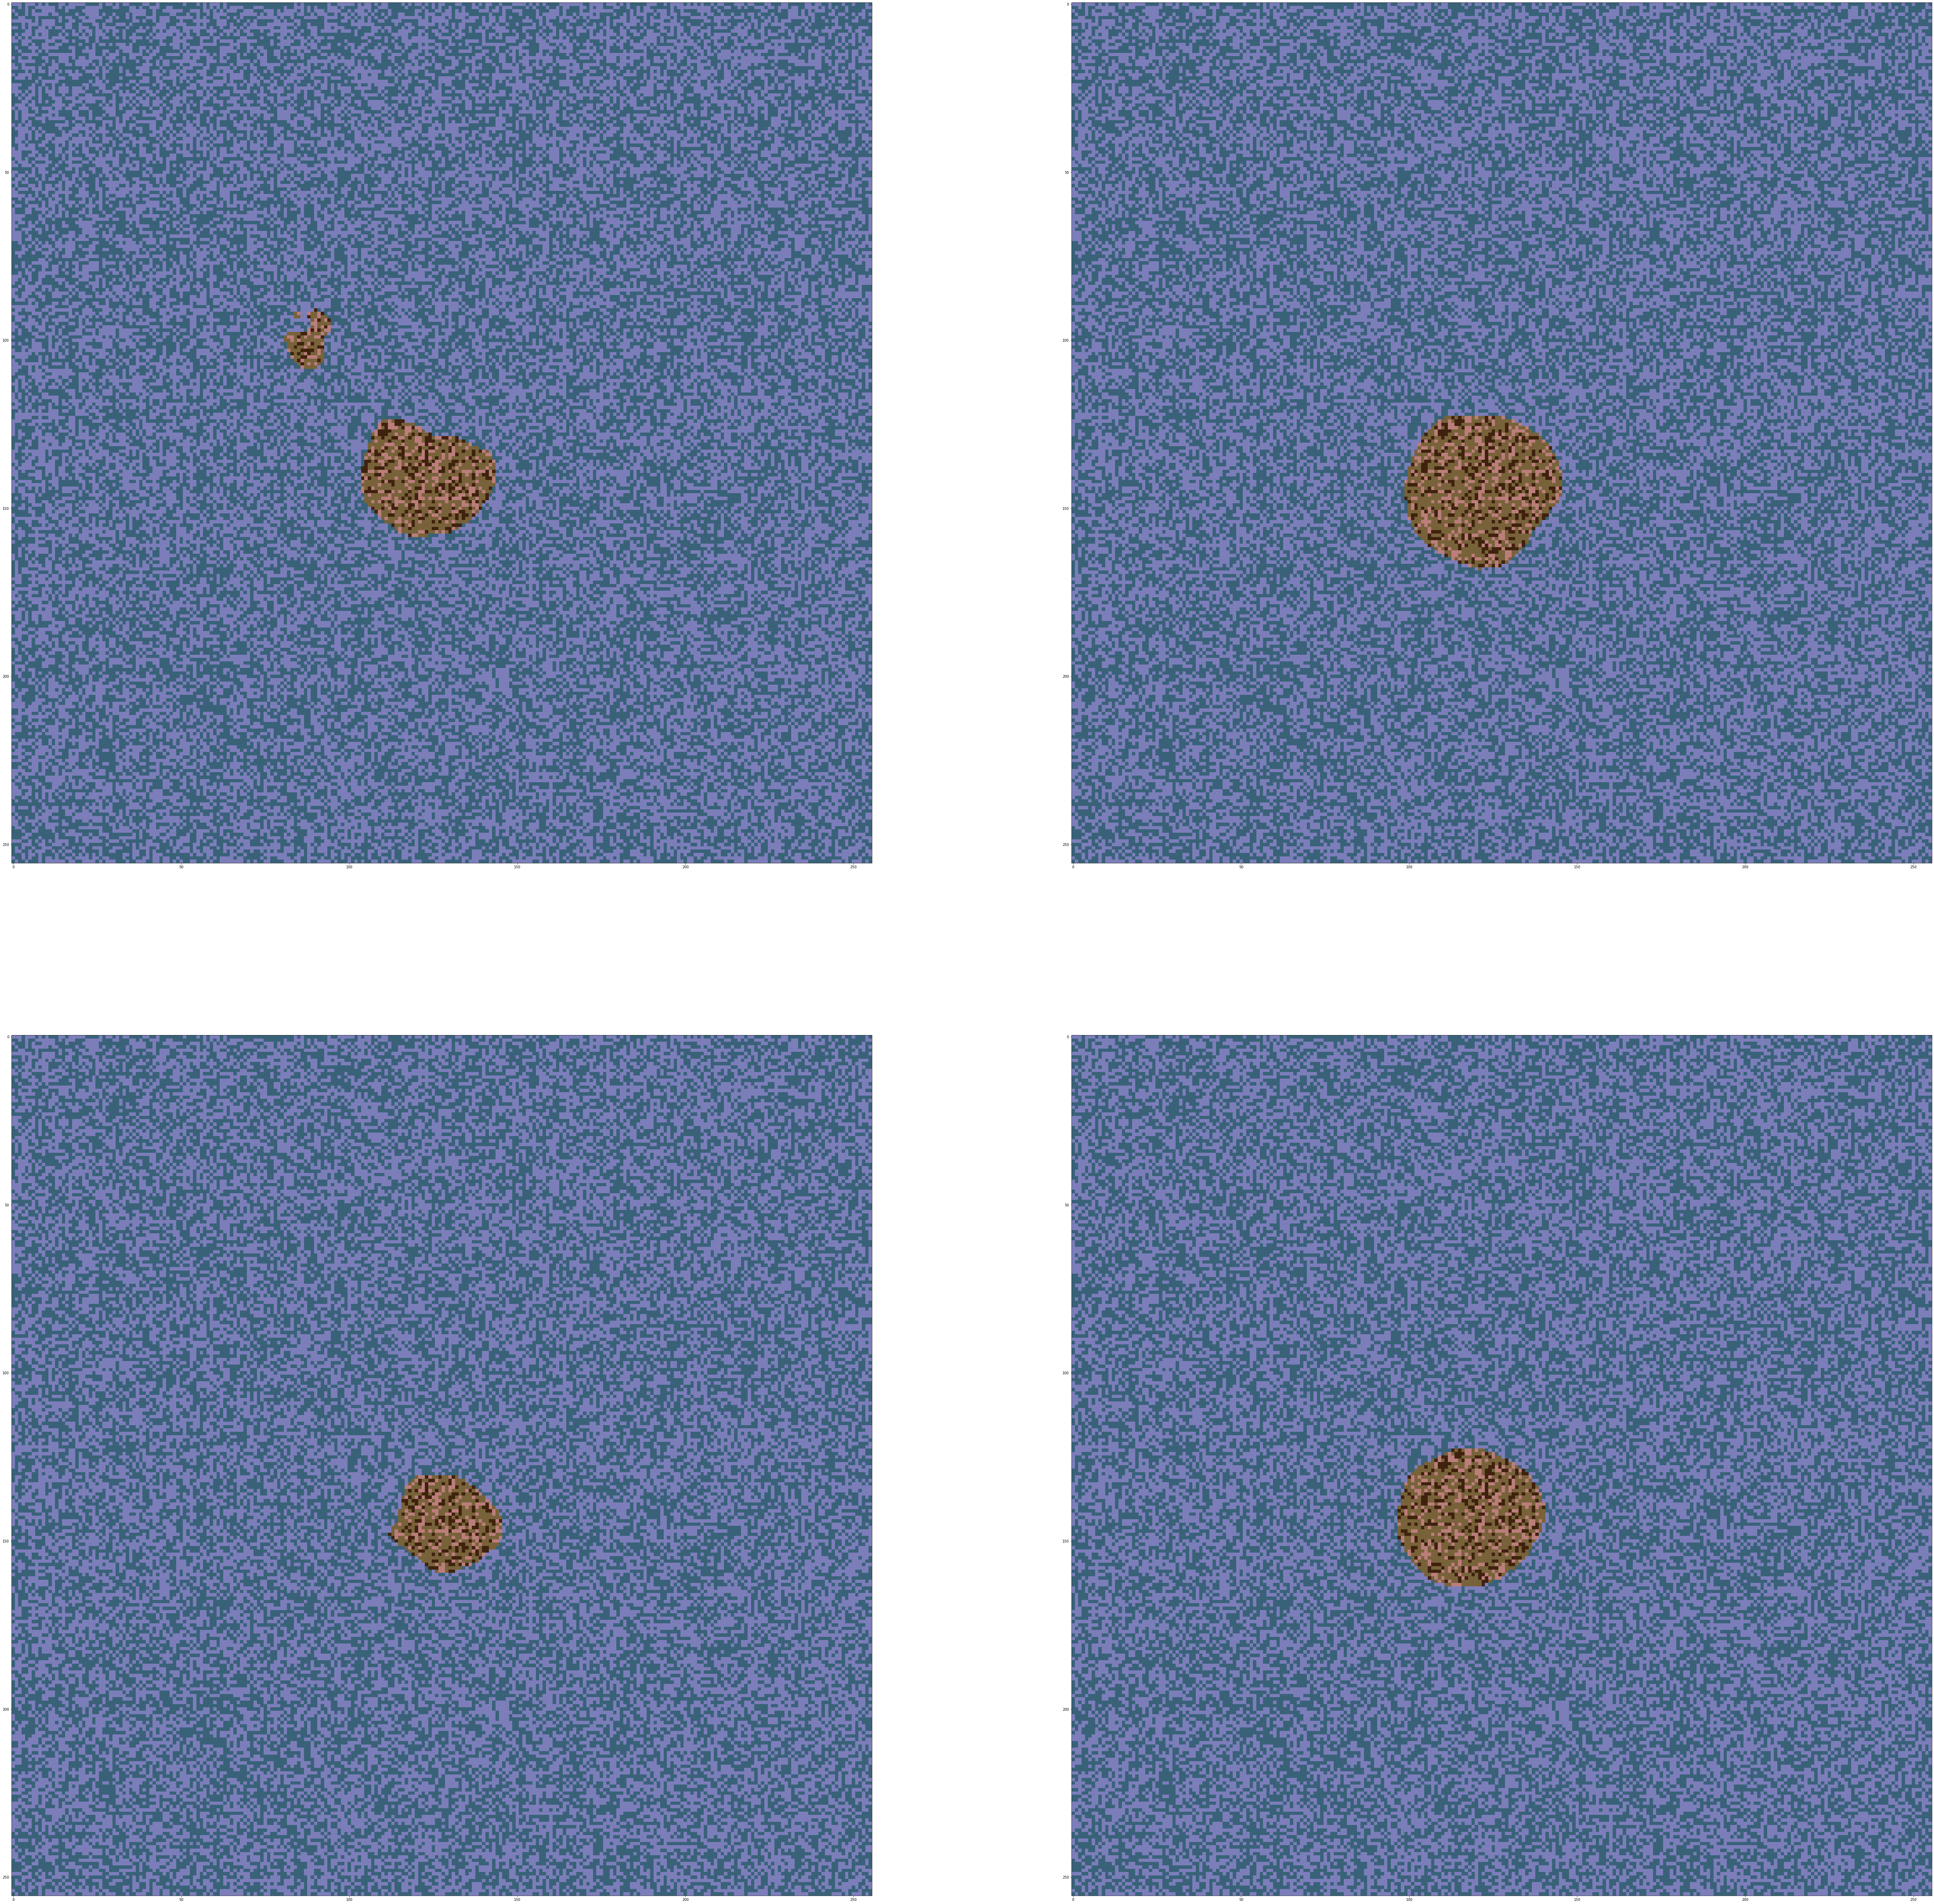

In [42]:



fig = plt.figure(figsize=(100, 100))
for j in range (4):

    plt.subplot(2, 2, j+1)
    plt.imshow(sample_rounded[j,1,:,:],cmap='Greens')
    plt.imshow(multichannel_data[j,1,:,:],cmap='jet', alpha= 0.5)
plt.show()


In [ ]:
## Testing the reshaping of the latent spaces:



In [12]:
array = np.arange(1,)
print(array)

[0 0 0 0]


In [2]:
temp = np.random(size=(10,10))

plt.imshow(temp)


TypeError: 'module' object is not callable